Author: Autumn Salsberry

Contact: linkedin.com/in/salsbeas

BrainStation Capstone: Predicting Adoptability of Shelter Dogs

August 8, 2022

This notebook is for the purpose of looking into the different modeling techniques within the Scikit-Learn package and determine if any of them can improve upon the logistic regression model built in the previous notebook. 

# Table of Contents

* [Checking the Data Frame](#check)
* [Base Logistic Regression Model](#base)
* [Choosing the Best Model](#best) 
    * [Tuning the Logistic Regression Model](#logreg)
        * [Evaluating the Logistic Model](#logregeval)
    * [Logistic Regression Using PCA](#pca)
    * [Tuning a Random Forest Model](#forest)
        * [Evaluating the Random Forest Model](#foresteval)   
* [Comparing the Models](#compare)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for sklearn ensemble 
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

# Goal

* Improve on the predictive power of the logreg model built in the previous notebook (5.5% improvement from base)

In [2]:
#read in the data (adopted vs. moved to partner or euthanized)
new_adopt_df = pd.read_csv('Tabular Data/new_adopt_category.csv')

In [3]:
#drop the key
new_adopt_df.drop('Animal ID', axis=1, inplace=True)

In [4]:
#make sure all caolumns are numeric
new_adopt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21462 entries, 0 to 21461
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stray                  21462 non-null  int64  
 1   normal_intake          21462 non-null  int64  
 2   age_in_months_intake   21462 non-null  float64
 3   adopted                21462 non-null  int64  
 4   age_in_months_outcome  21462 non-null  float64
 5   sex                    21462 non-null  int64  
 6   fixed_intake           21462 non-null  int64  
 7   fixed_changed          21462 non-null  int64  
 8   retriever              21462 non-null  int64  
 9   shepherd               21462 non-null  int64  
 10  beagle                 21462 non-null  int64  
 11  terrier                21462 non-null  int64  
 12  boxer                  21462 non-null  int64  
 13  poodle                 21462 non-null  int64  
 14  rottweiler             21462 non-null  int64  
 15  da

# Checking the Data Frame
<a class="anchor" id="check"></a>

Before modeling, I will confirm the data frame is ready for modeling by checking for null values and distributions of the independent variables. After this initial check, I will split the data into train, validation and test sets and confirm that the split data reflects the same distribution as the original data frame. 

In [5]:
#check for nulls
new_adopt_df.isna().sum().sum()

0

In [6]:
# set the target variable and indepdent variables
X = new_adopt_df.drop('adopted', axis=1) # independent variables or features
y = new_adopt_df['adopted'] # dependent variable or target

#check that their shapes are consistent
print(X.shape)
print(y.shape)

(21462, 56)
(21462,)


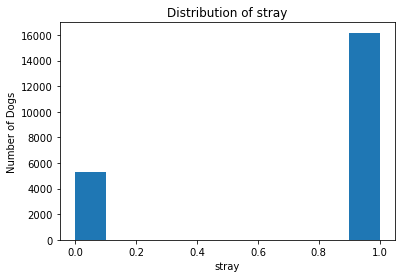

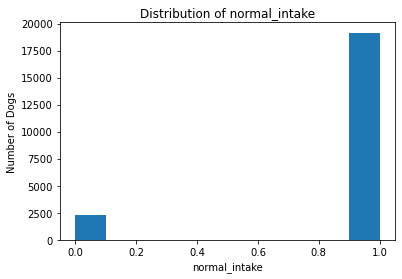

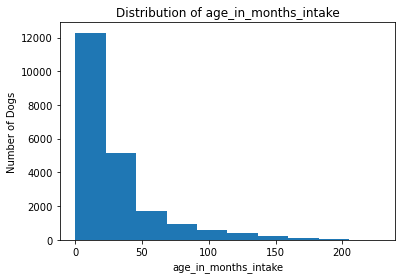

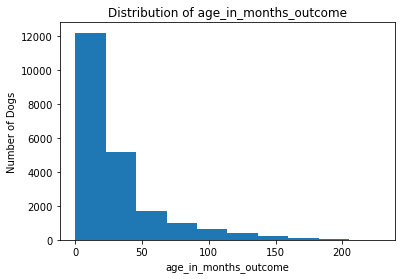

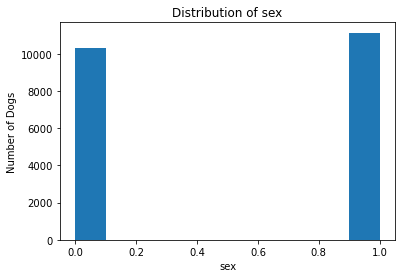

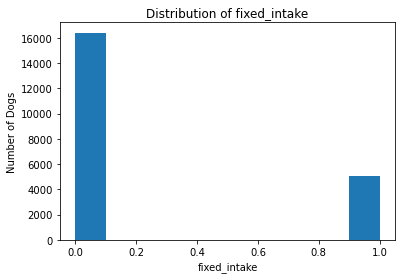

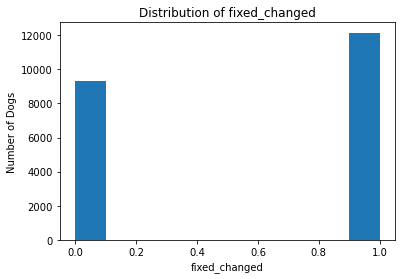

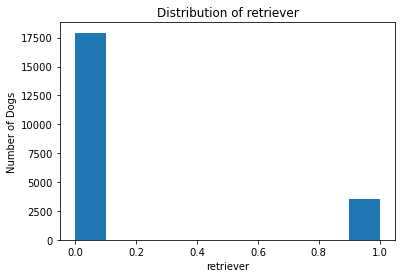

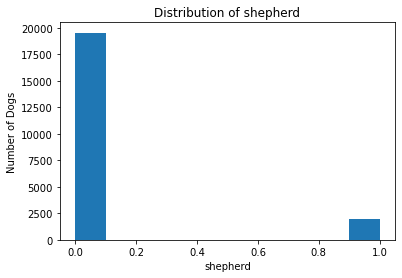

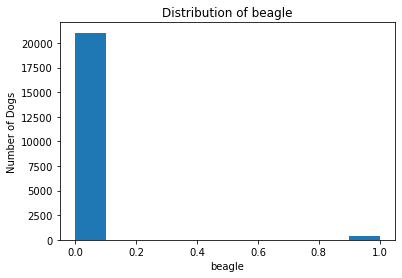

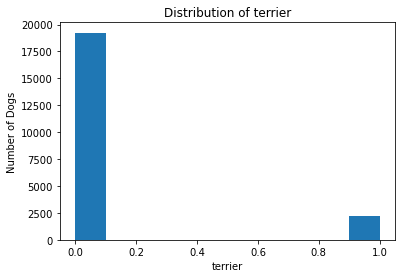

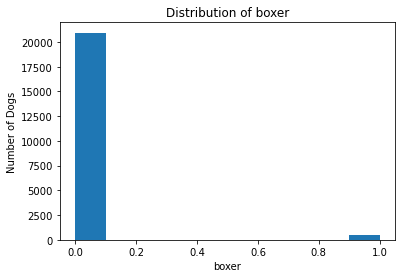

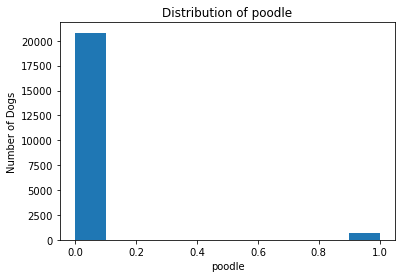

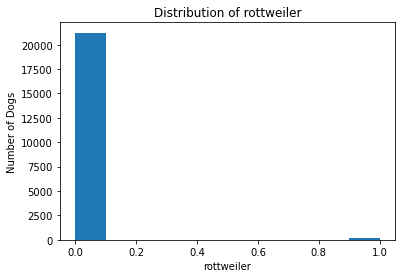

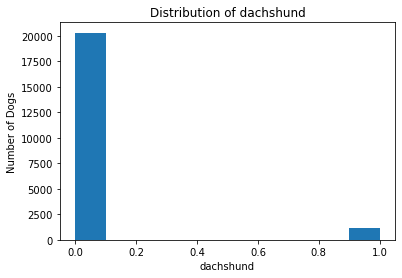

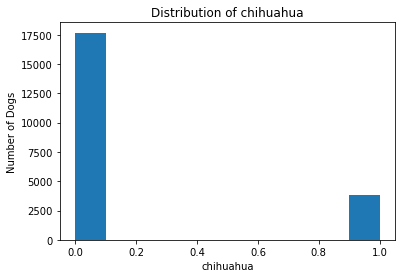

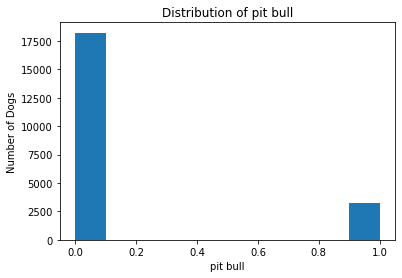

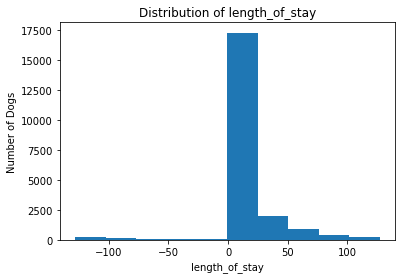

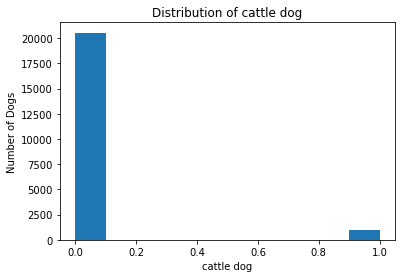

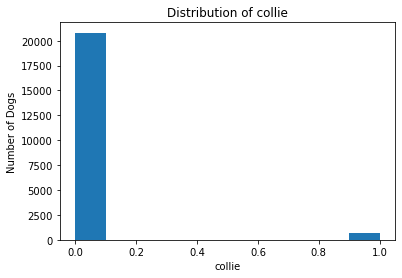

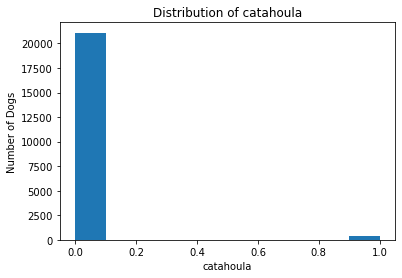

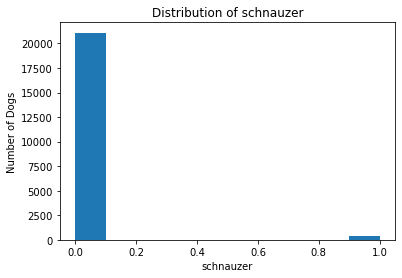

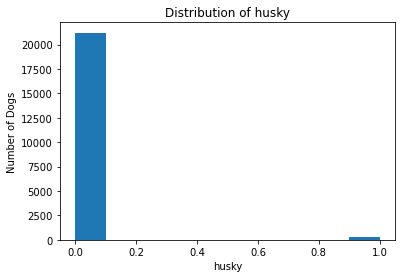

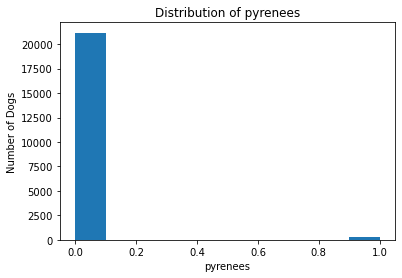

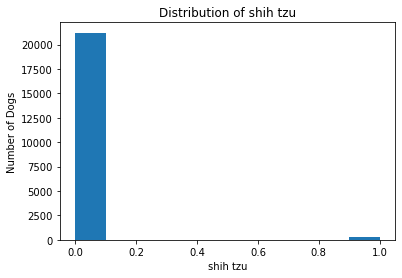

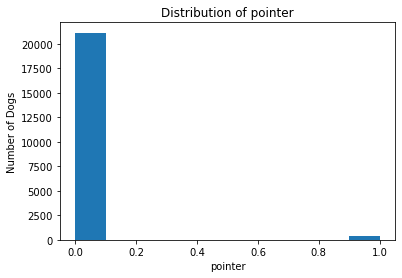

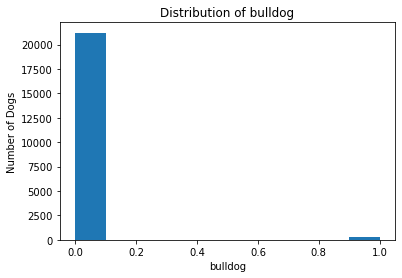

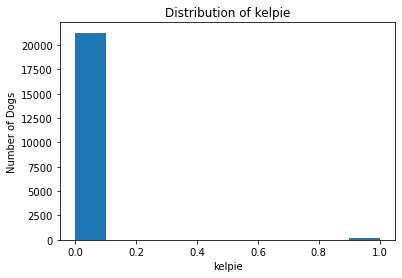

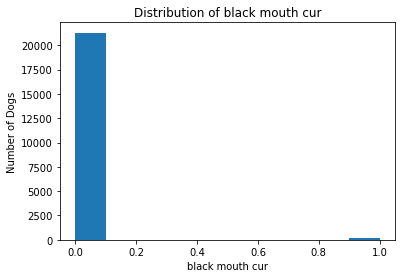

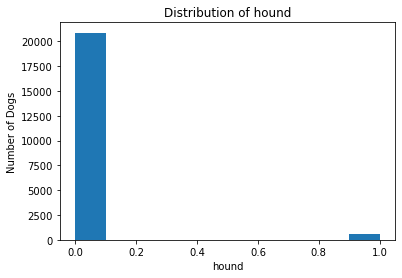

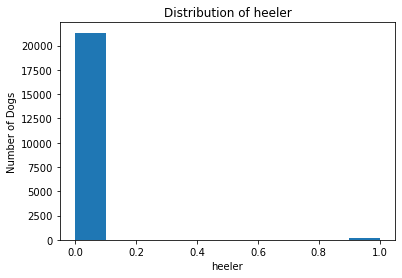

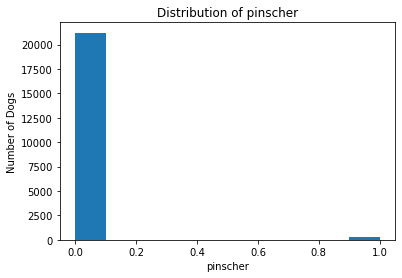

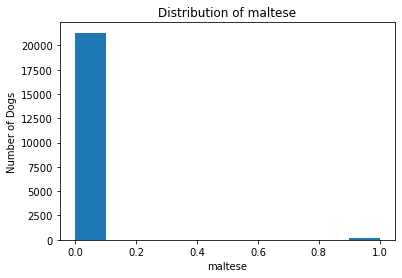

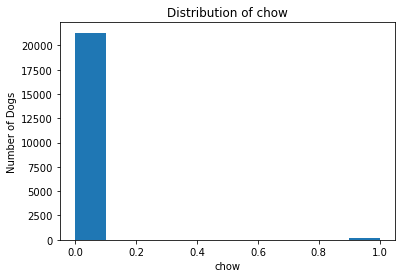

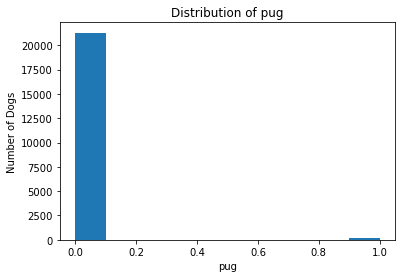

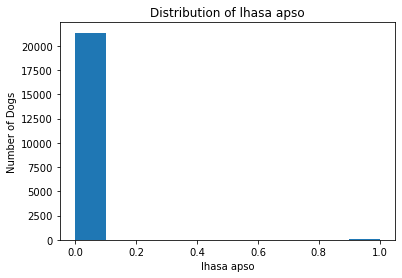

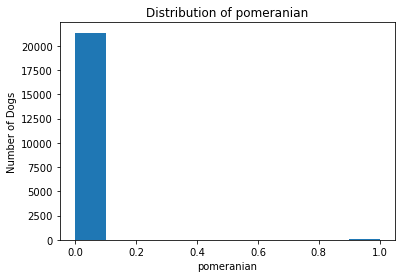

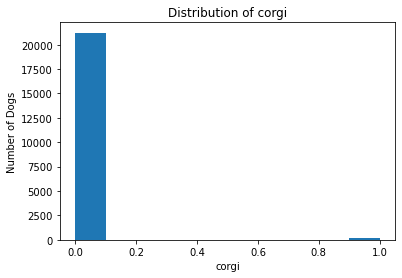

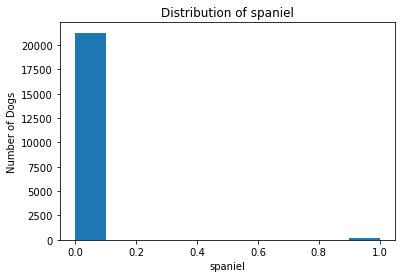

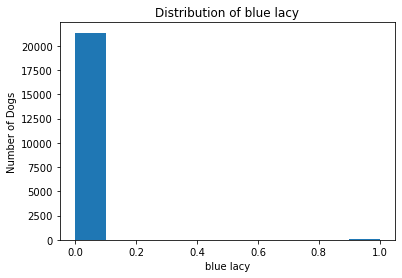

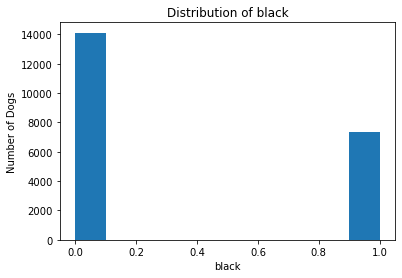

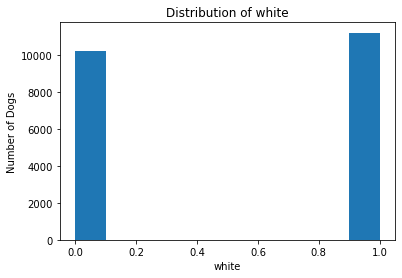

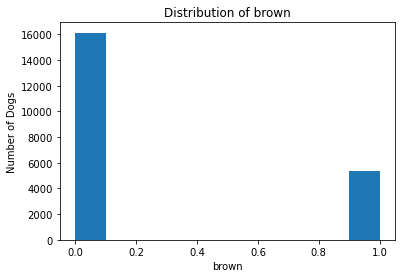

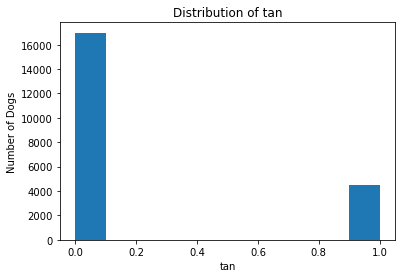

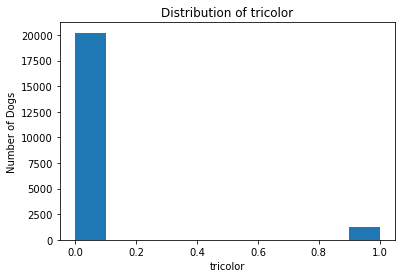

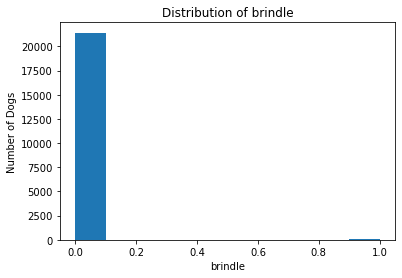

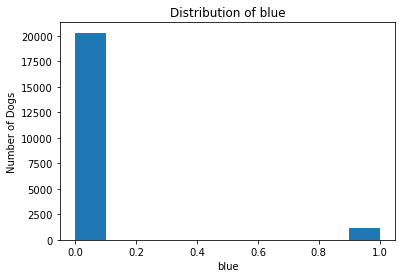

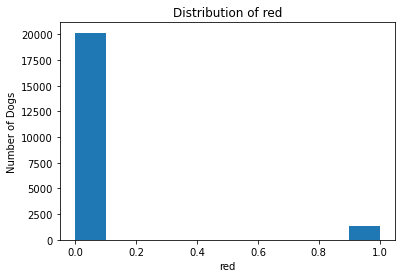

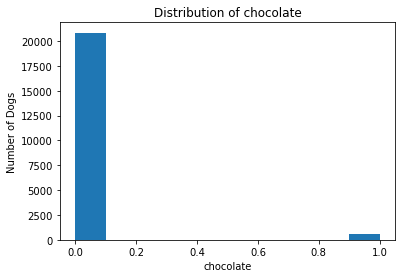

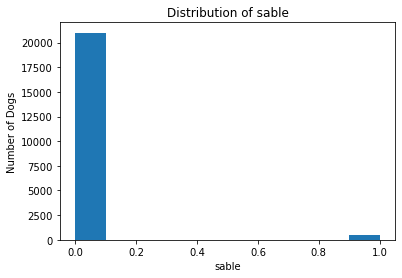

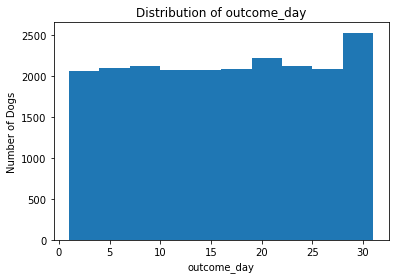

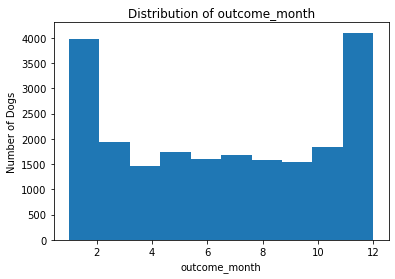

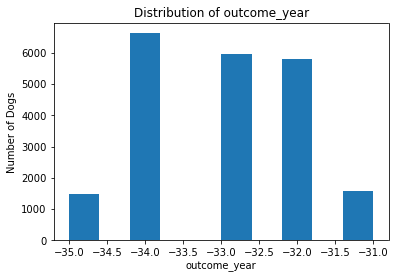

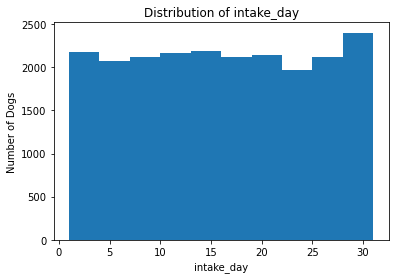

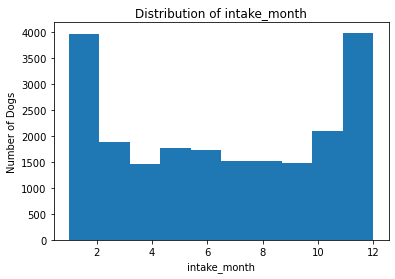

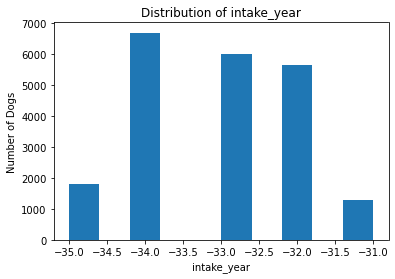

In [7]:
#what are the distributions of each of the independent variables?
for i in range(len(X.columns)):
    plt.figure()
    plt.hist(X[f"{X.columns[i]}"])
    plt.xlabel(f"{X.columns[i]}")
    plt.ylabel('Number of Dogs')
    plt.title(f"Distribution of {X.columns[i]}")
    plt.show()


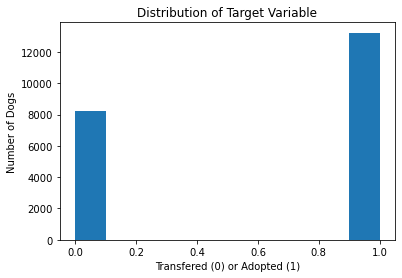

In [8]:
plt.figure()
plt.hist(y)
plt.xlabel('Transfered (0) or Adopted (1)')
plt.ylabel('Number of Dogs')
plt.title('Distribution of Target Variable')
plt.show()

Most of this data is highly skewed. This is due to the nature of the cleaned data where many of the columns are OneHotEncoded. For example, though there are many dogs that are brown, there are simply too many coat colors and thus, most dogs are not brown and therefore there is a significant left skew for this variable. The target variable is right skewed meaning most dogs are in fact adopted in this data frame. It is not clear if this is a representation of reality or if it is due to the choice of how to create this target variable. As discussed at length in the previous notebook, this target variable seems more objective in the sense that dogs that are not adopted are not likely to be adopted, while another dataset, I could have included dogs who already have a family in the not adoptable class. Without further ado, I will split the data into train, validation and test sets. 

In [9]:
#remain test split
X_remain, X_test, y_remain, y_test = tts(X, y, test_size=0.3, stratify=y, random_state=3)

In [10]:
#confirm the shapes are consistent
print(X_remain.shape)
print(X_test.shape)
print(y_remain.shape)
y_test.shape

(15023, 56)
(6439, 56)
(15023,)


(6439,)

In [11]:
#create validation set
X_train, X_val, y_train, y_val = tts(X_remain, y_remain, test_size=0.3, stratify=y_remain, random_state=2)

In [12]:
#confirm the shapes are consistent
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
y_val.shape

(10516, 56)
(4507, 56)
(10516,)


(4507,)

Now that I have the data split, I can use the train and validation sets to build and test the models predictive power. Once I have fine tuned the models and completed hyper parameterization, I can the train and validation sets together to train the model and use the test set (which the model has never seen before) to choose the model with the best predictive power. This will assure there is nor data leakage and the chosen model will be more generalizable to other data outside of the Austin, TX dataset. 
But first, I would like to confirm the distributions of the train and validation set are the same as the entire dataset. 

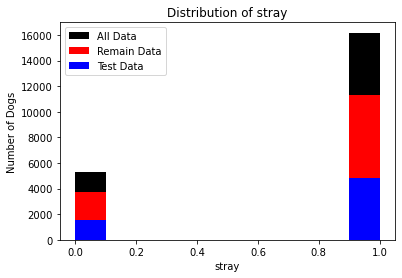

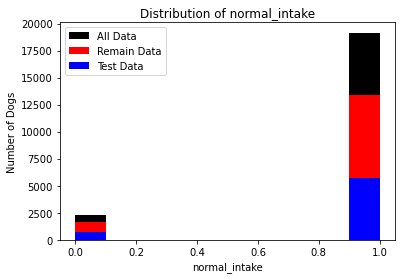

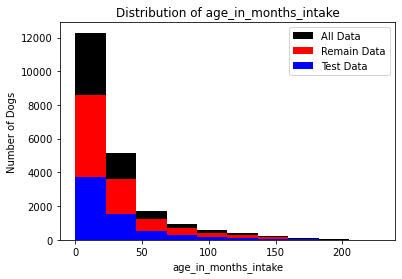

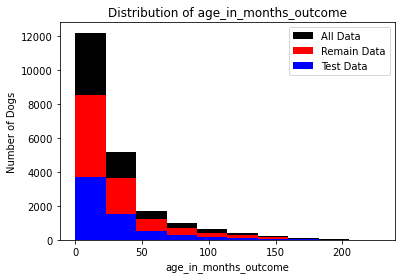

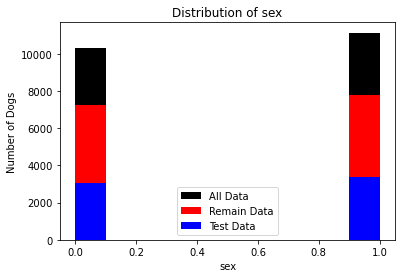

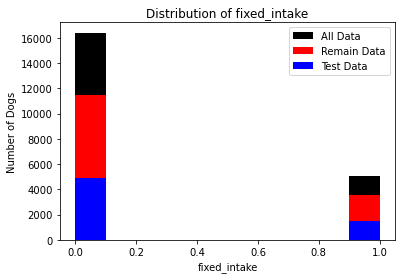

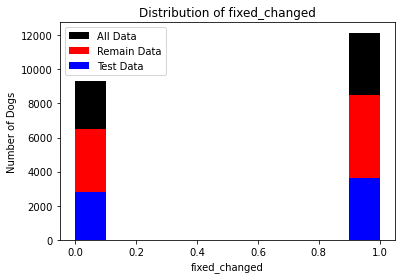

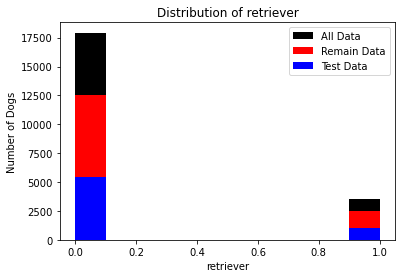

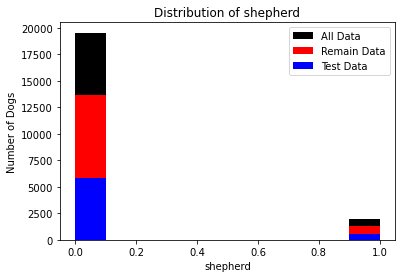

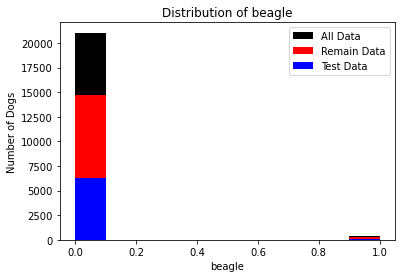

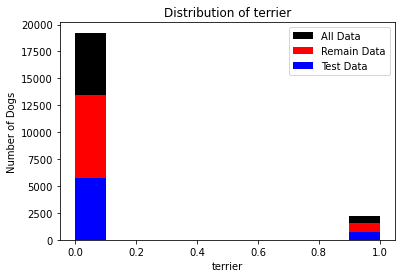

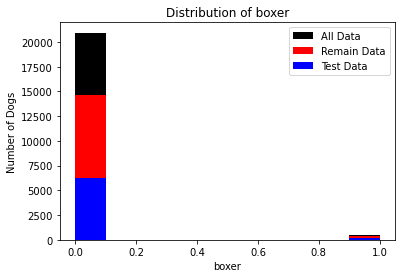

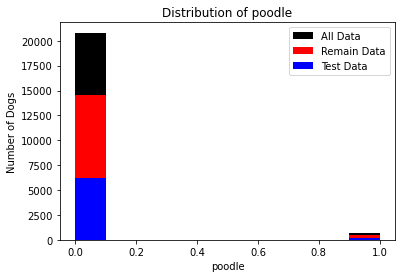

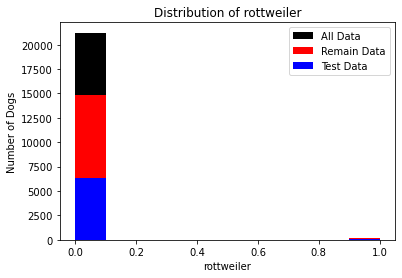

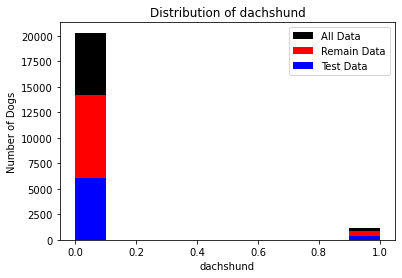

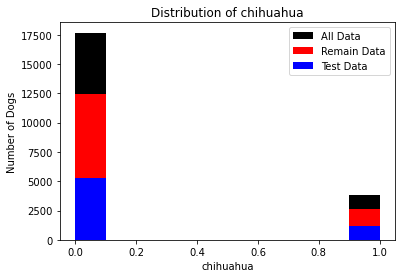

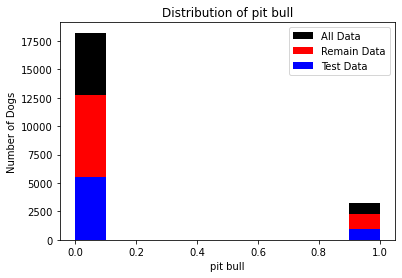

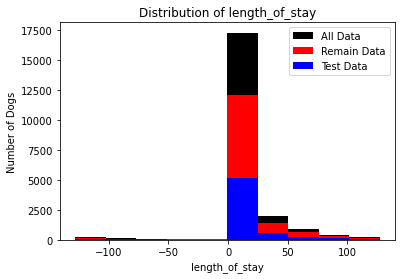

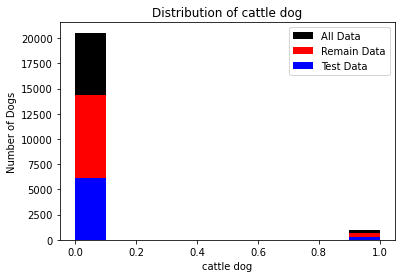

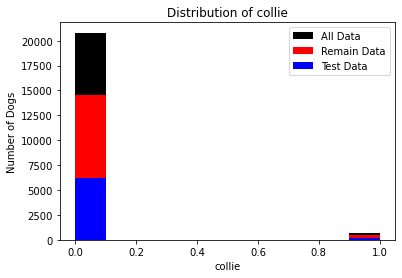

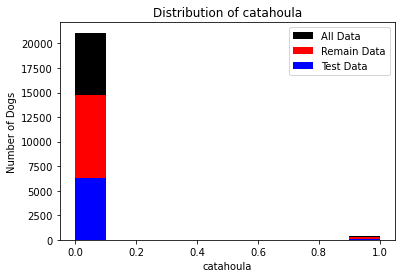

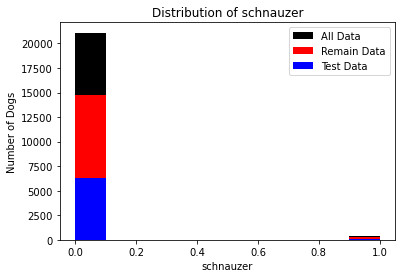

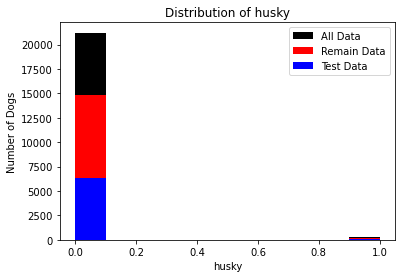

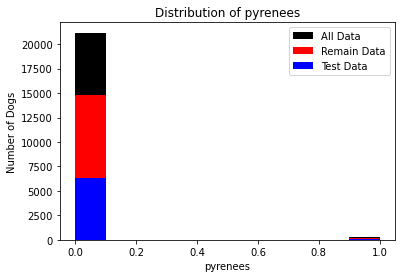

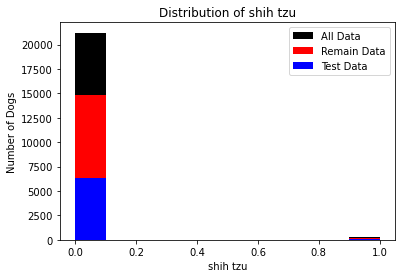

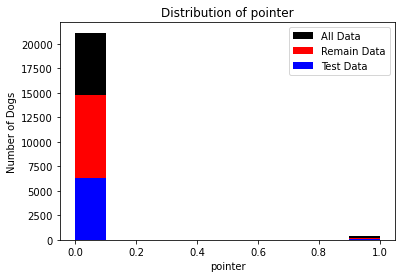

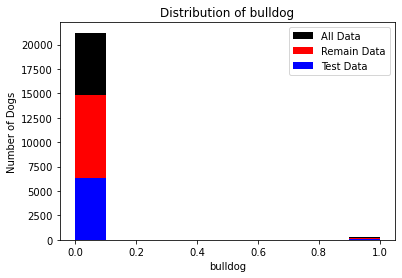

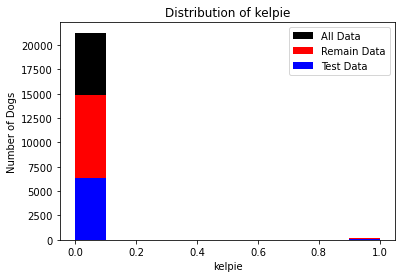

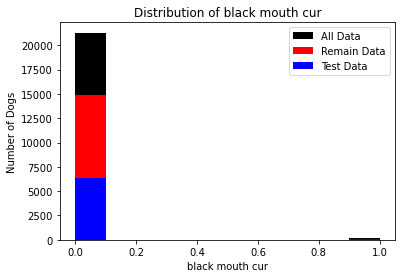

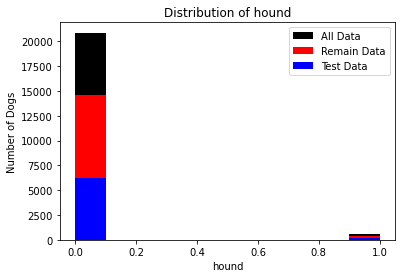

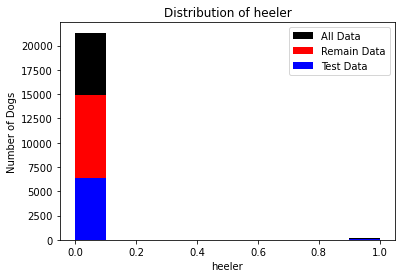

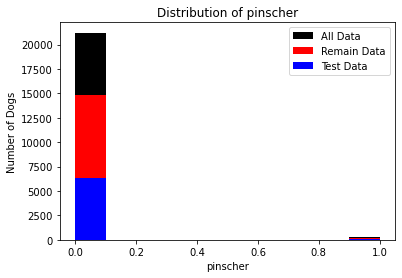

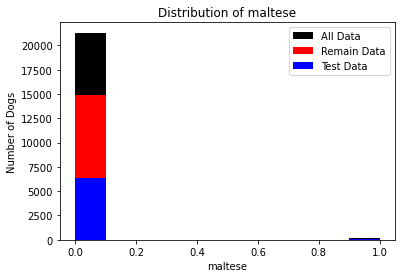

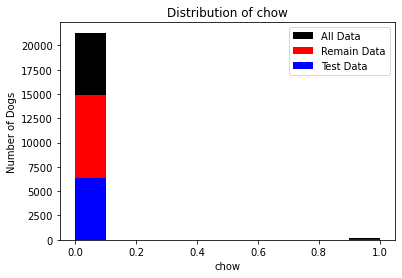

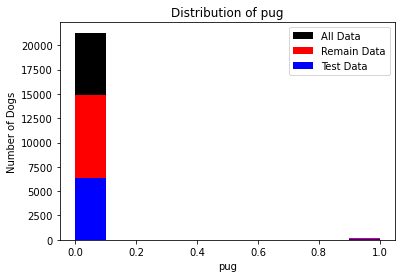

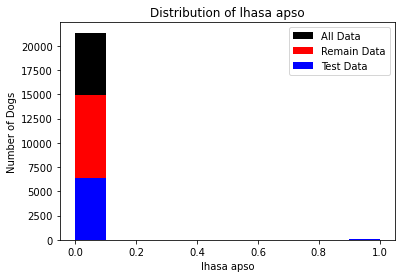

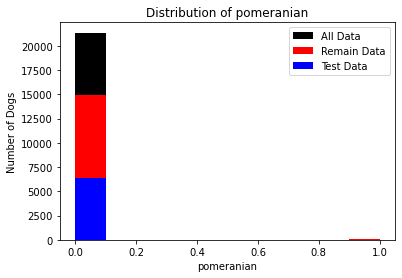

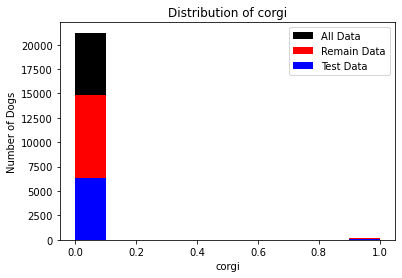

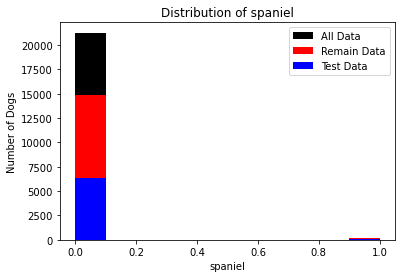

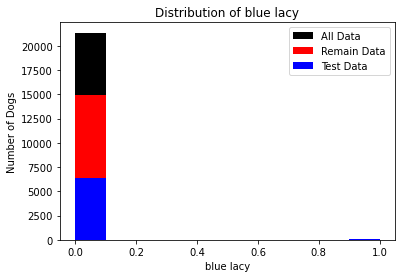

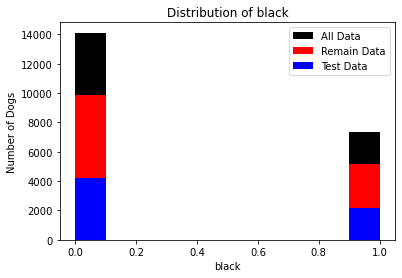

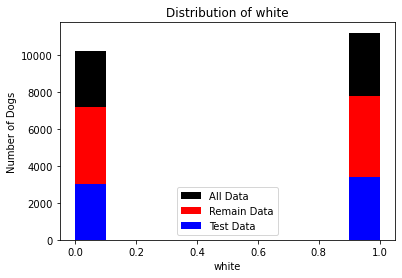

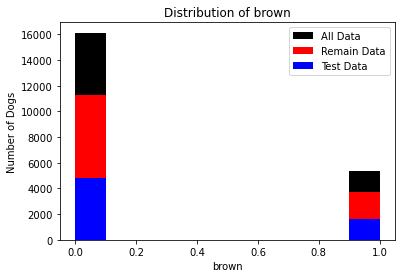

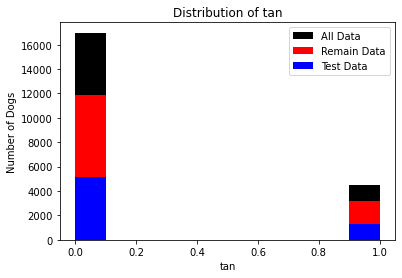

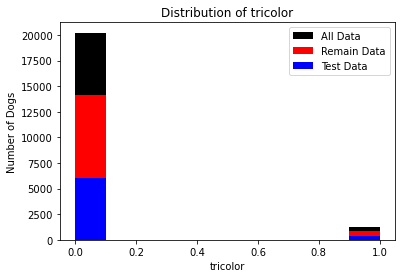

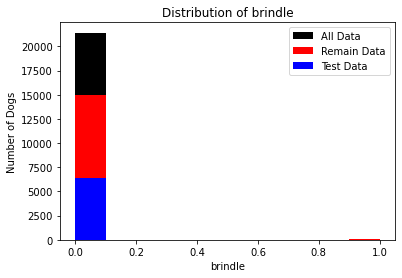

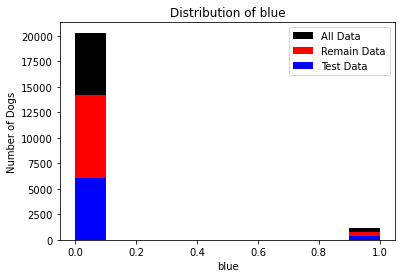

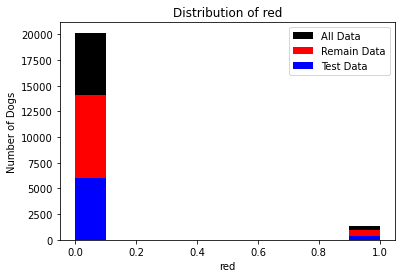

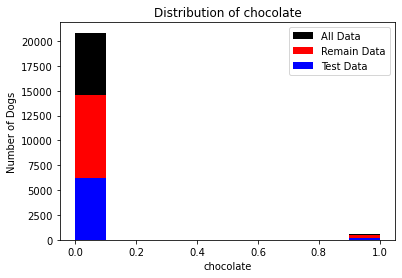

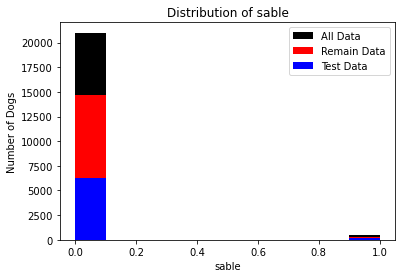

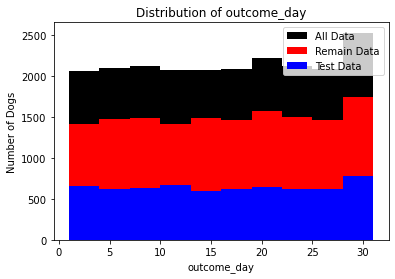

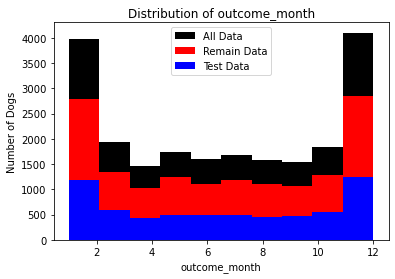

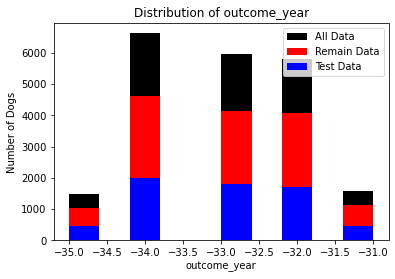

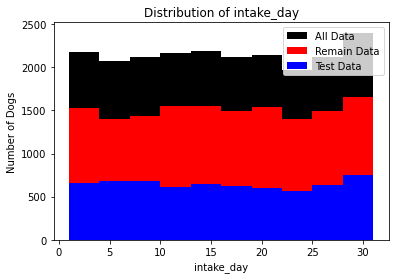

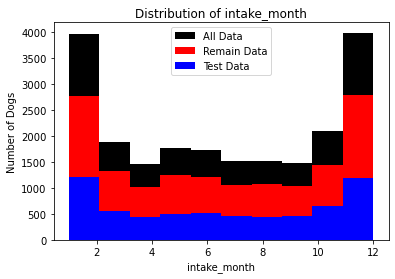

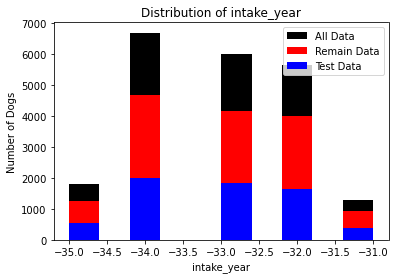

In [13]:
#each distribution is ontop of the previous, so they should be praportional

for i in range(len(X_remain.columns)):    
    plt.figure()
    plt.hist(X[f'{X_remain.columns[i]}'], color='black', label='All Data')
    plt.hist(X_remain[f'{X_remain.columns[i]}'], color='red', label='Remain Data')
    plt.hist(X_test[f'{X_remain.columns[i]}'], color='blue', label='Test Data')
    plt.xlabel(f'{X_remain.columns[i]}')
    plt.ylabel('Number of Dogs')
    plt.title(f'Distribution of {X_remain.columns[i]}')
    plt.legend()
    plt.show()

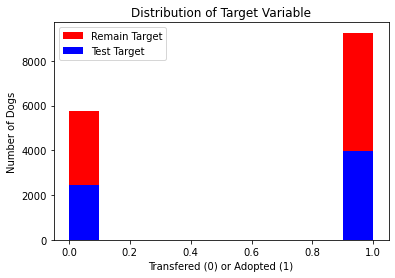

In [14]:
plt.figure()
plt.hist(y_remain, color='red', label='Remain Target')
plt.hist(y_test, color='blue', label='Test Target')
plt.xlabel('Transfered (0) or Adopted (1)')
plt.ylabel('Number of Dogs')
plt.title('Distribution of Target Variable')
plt.legend()
plt.show()

By layering the corresponding variables on top of each other I can easily compare the proportions of each class with the proportions of the other sets. It looks like the remain (both train and validation together) and test sets are representative of the entire dataset and are safe to be used for model evaluations. 
Next, I will do the same for the train and validation sets. 

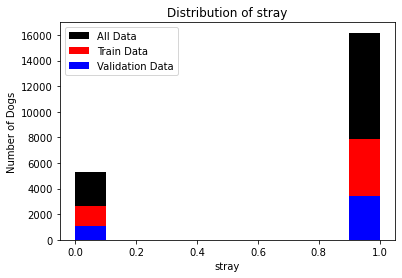

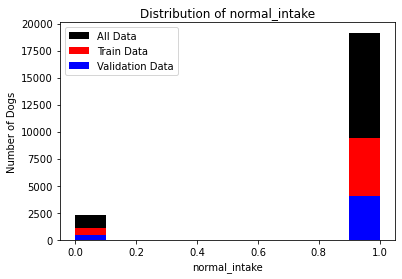

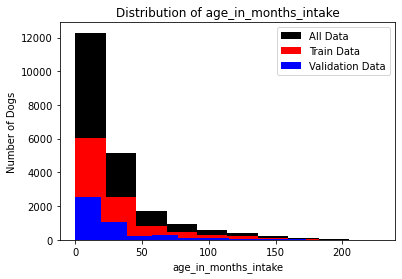

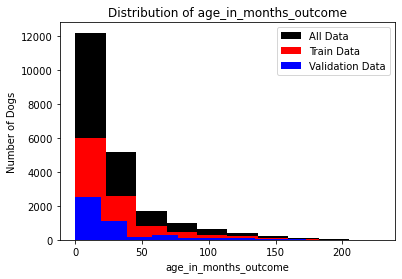

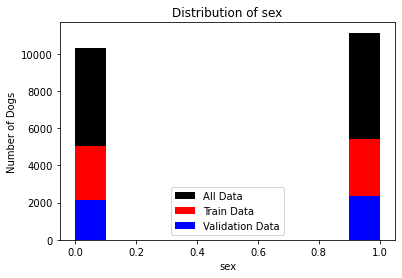

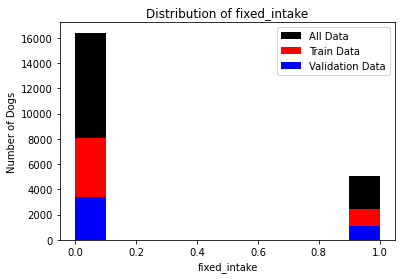

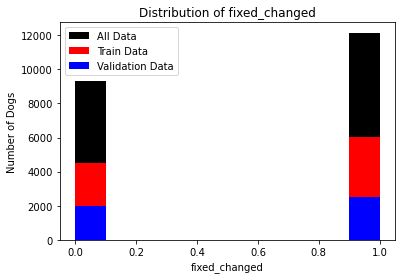

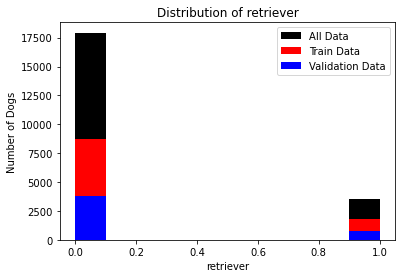

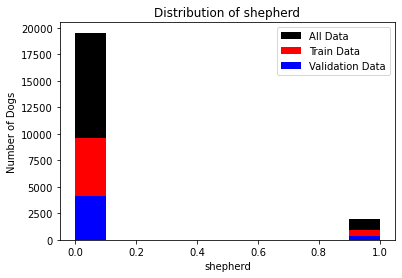

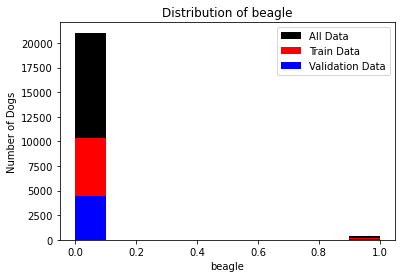

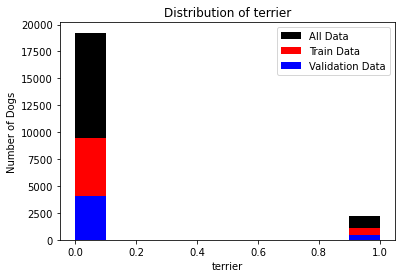

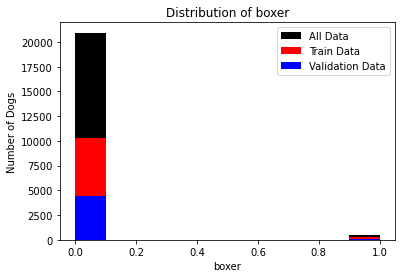

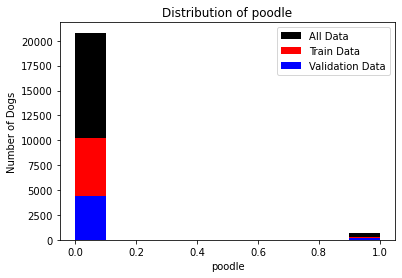

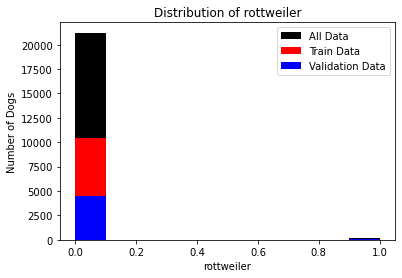

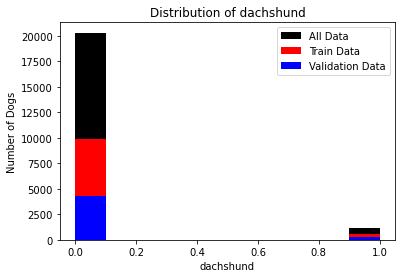

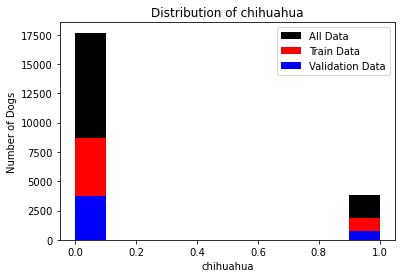

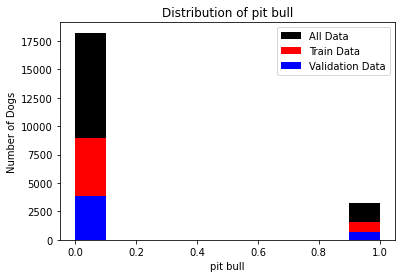

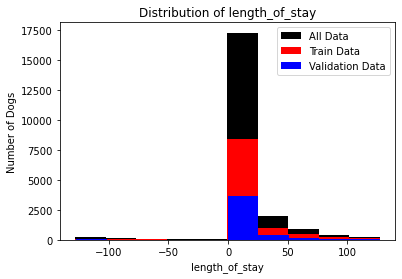

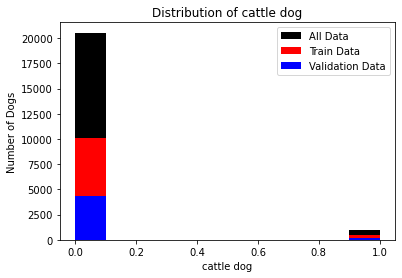

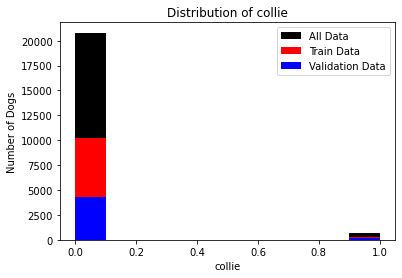

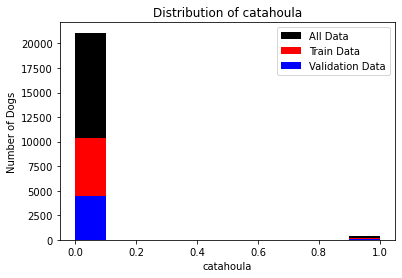

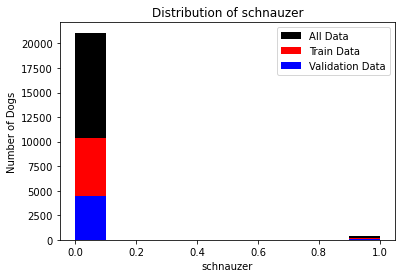

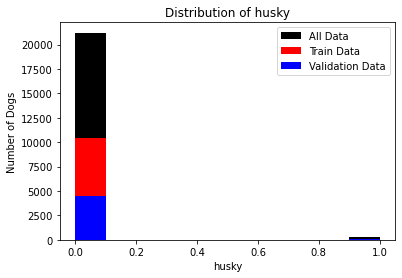

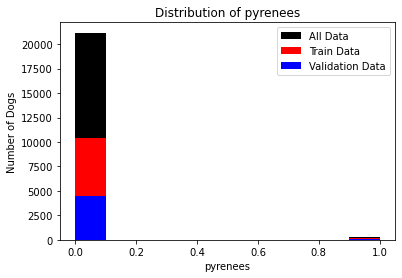

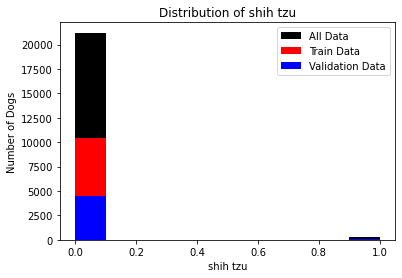

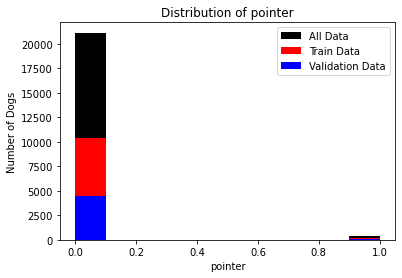

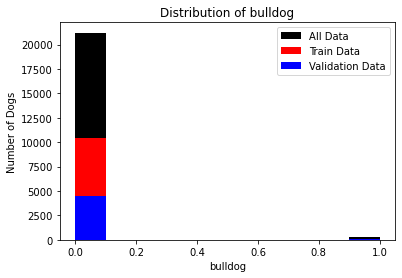

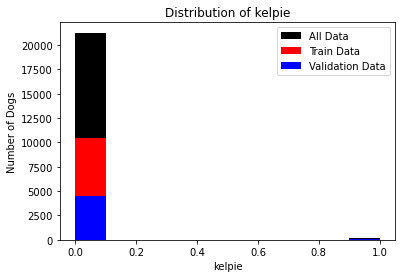

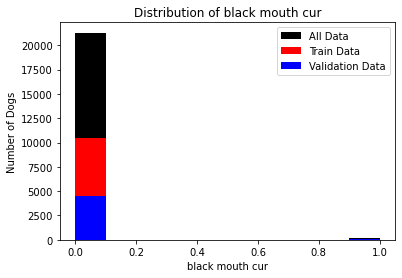

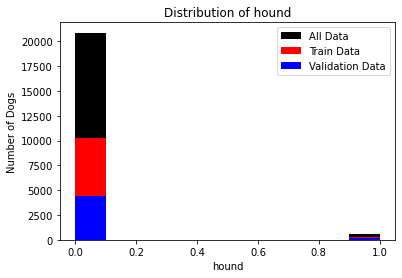

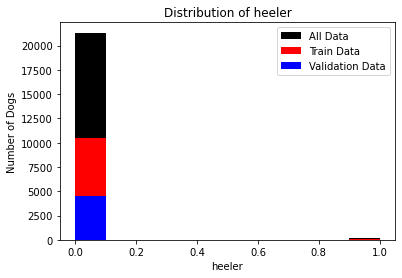

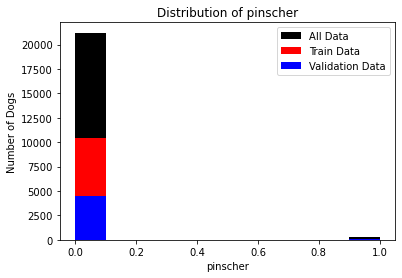

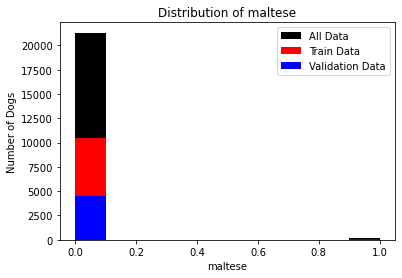

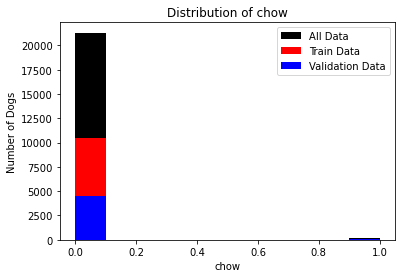

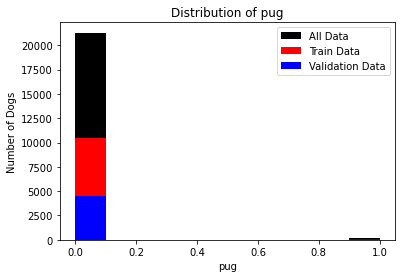

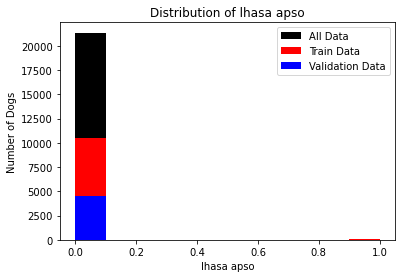

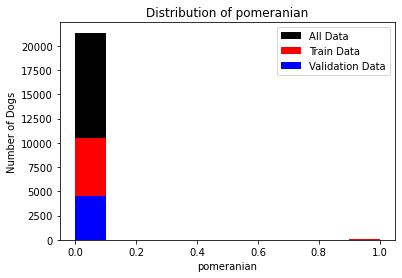

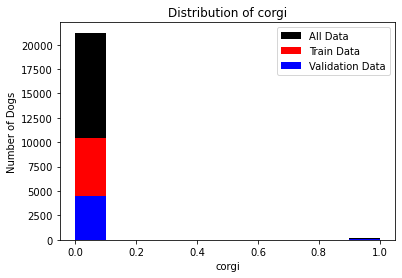

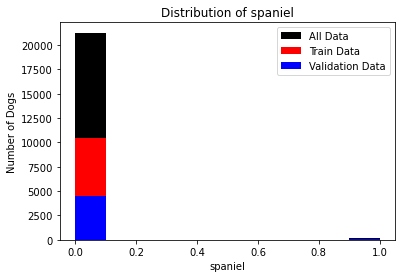

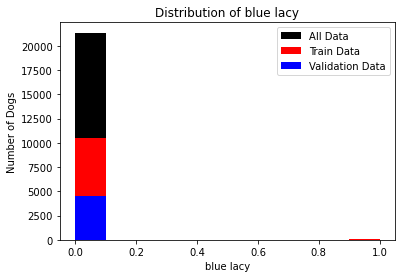

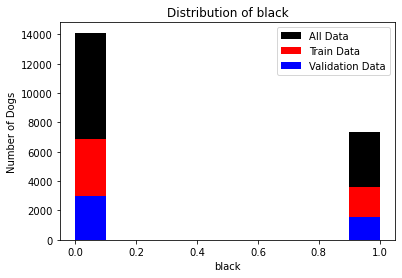

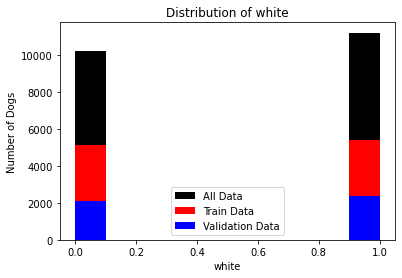

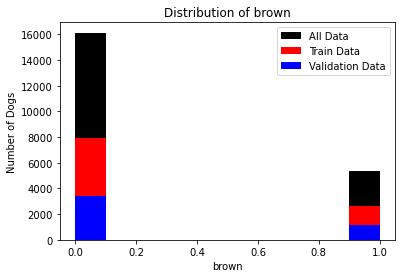

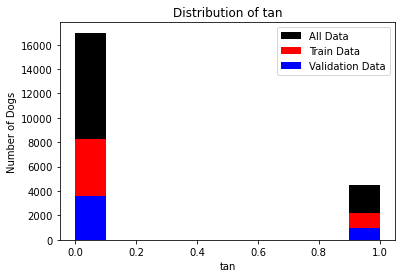

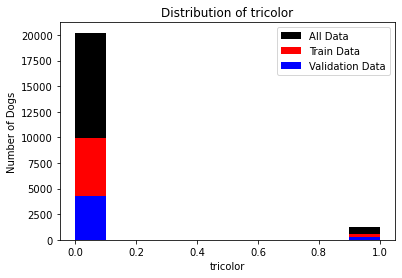

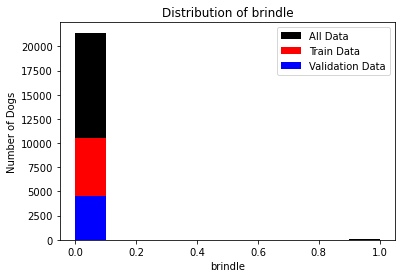

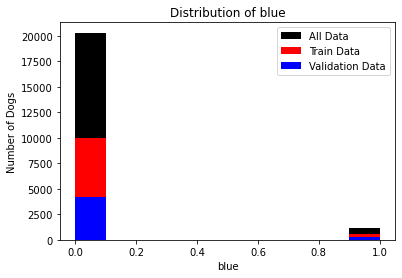

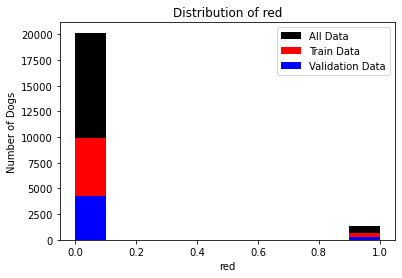

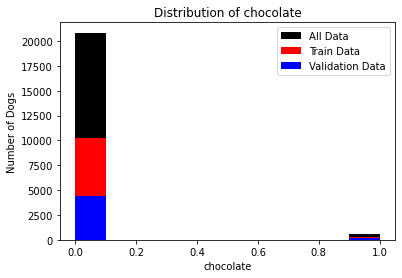

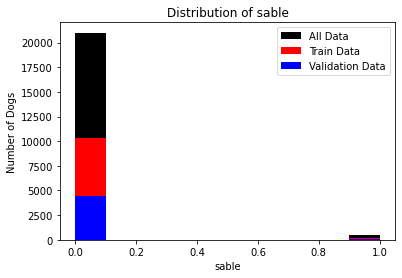

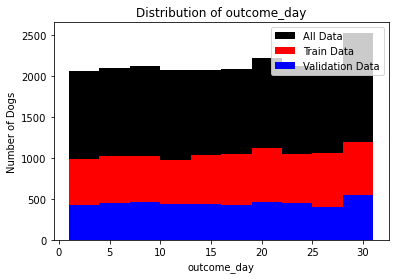

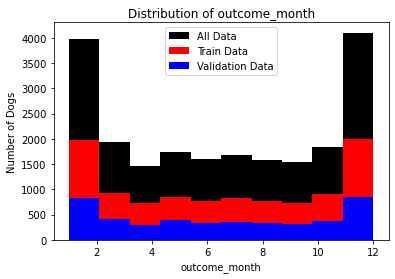

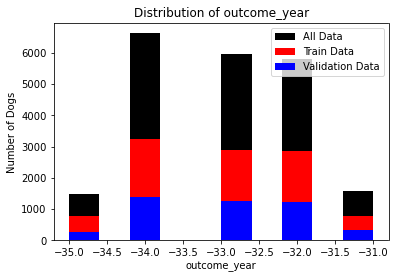

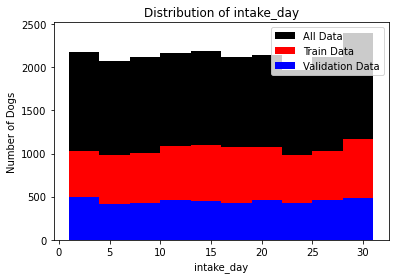

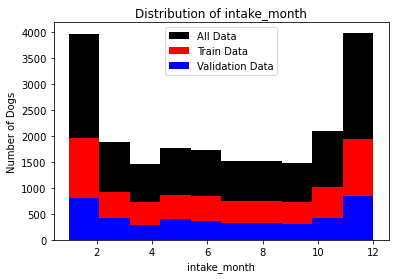

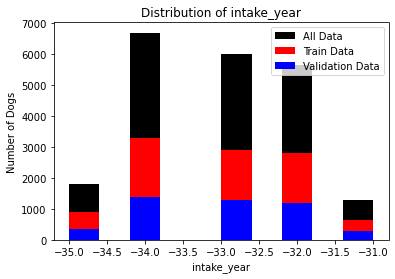

In [15]:
#each distribution is ontop of the previous, so they should be praportional

for i in range(len(X_train.columns)):    
    plt.figure()
    plt.hist(X[f'{X_train.columns[i]}'], color='black', label='All Data')
    plt.hist(X_train[f'{X_train.columns[i]}'], color='red', label='Train Data')
    plt.hist(X_val[f'{X_train.columns[i]}'], color='blue', label='Validation Data')
    plt.xlabel(f'{X_train.columns[i]}')
    plt.ylabel('Number of Dogs')
    plt.title(f'Distribution of {X_remain.columns[i]}')
    plt.legend()
    plt.show()

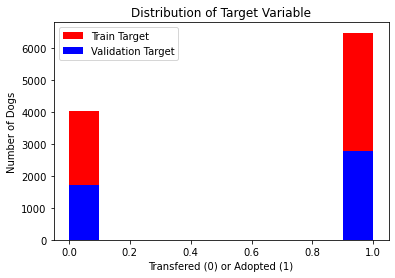

In [16]:
plt.figure()
plt.hist(y_train, color='red', label='Train Target')
plt.hist(y_val, color='blue', label='Validation Target')
plt.xlabel('Transfered (0) or Adopted (1)')
plt.ylabel('Number of Dogs')
plt.title('Distribution of Target Variable')
plt.legend()
plt.show()

Generally speaking this split looks representative of the entire dataset as well. The age_in_months_outcome distribution is slightly different in the validation set, but not so much so that it causes great concern. Now I will scale the data in preparation for modeling. 

In [17]:
#scale the train/val data with same fit
scaler_train = StandardScaler()
scaler_train.fit(X_train)
X_train_scale = scaler_train.transform(X_train)
X_val_scale = scaler_train.transform(X_val)

#scale the remain/test data with different fit from above
scaler_remain = StandardScaler()
scaler_remain.fit(X_remain)
X_remain_scale = scaler_remain.transform(X_remain)
X_test_scale = scaler_remain.transform(X_test)

# Base Logistic Regression
<a class="anchor" id="base"></a>

Now that I am ready for modeling, I will run a quick Logistic Regression model to compare the results of this model with the Logistic Regression model built in the previous notebook on the same data. 

In [18]:
# 1. Instantiate model 
logreg_model = LogisticRegression()

# 2. Fit model on the training data
    #use scaled data to assure consistency in all models
logreg_model.fit(X_train_scale, y_train)

# 3. Score on the training data 
print(f"The train data accuracy is: {round(logreg_model.score(X_train_scale, y_train), 4)*100}%")

# 4. Score on the testing data
print(f"The val data accuracy is: {round(logreg_model.score(X_val_scale, y_val), 4)*100}%")

The train data accuracy is: 80.0%
The val data accuracy is: 79.72%


In [19]:
base_rate = y.sum()/y.count()
f"That is a {(round(logreg_model.score(X_val_scale, y_val) - base_rate, 4))*100}% improvement on base."

'That is a 18.099999999999998% improvement on base.'

This is looking great, the model is not over fitting very much and the validation set is getting a 18% improvement in predictive power compared with the 5.5% achieved in the previous notebook. All of that without doing any hyper parameterization! That is a good sign that I can get a significant result comparable to the predictive power of the first logistic model in the previous notebook (using the adopted vs any other outcome data target split). Now that I have high spirits, I will run a quick comparison of a few of the models the Scikit-Learn package offers and see which are worth diving into more. 

# Choosing the Best Model Type
<a class="anchor" id="best"></a>

Some Scikit-Learn models I would like to test out and compare to the logistic regression just ran is support vector machines (SVMs), decision tree, random forest, and k nearest neighbors (KNN). SVMs are not commonly used in this kind of situation, but it can handle both classification and regression on linear and non-linear data, so it is work considering. Decision tree is a model with a lot of explainability because it simply makes binary decisions to a specified depth. Each of these decisions are clear. Random forest is an ensemble model of decision trees. It is slightly less explainable, but rooted in the logic just explained with improved predictive power due to increased probability using generalizing strategies. KNNs are also relatively easy to explain because it simply compares a point with a specific number points closest to it and makes a prediction on its outcome based on the outcomes of those "neighbors". 

In [20]:
#instantiate the models I want to use and save them in a dictionary
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

To evaluate these models I will consider their accuracy (how many times they predicted the correct outcome divided by how many dogs total), precision (how many dogs the model accurately predicted as adoptable divided by all of the dogs it predicted as adoptable), and the recall (how many dogs the model accurately predicted as adoptable divided by how many dogs were actually adopted). 
The precision reflects how reliable the model is in classifying dogs as adoptable. If the precision is low, then dogs are being considered "adoptable" when in fact they not likely to be adopted. This can be a waste of resources and space for the shelter and could ultimately put them out of business in extreme cases. 
Recall, on the other hand, cares only about how the positive samples are classified. This is independent of how the negative samples are classified. This is important because dogs that are going to be adopted should stay at the shelter and be available for families to see them and adopt them. Thus, if recall is low, the shelter might be moving dogs or even euthanizing them even though they are capable of finding a forever homes.

Note:
Precision = TruePositives / (TruePositives + FalsePositives)
Recall = TruePositives / (TruePositives + FalseNegatives)

In [21]:
#fit each of these models (without hyper parameterization) and check accuracy, precision and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_val)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_val)
    precision[key] = precision_score(predictions, y_val)
    recall[key] = recall_score(predictions, y_val)
    
#source: https://www.learndatasci.com/glossary/binary-classification/

C:\Users\salsb\anaconda3\envs\autumn_deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\salsb\anaconda3\envs\autumn_deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [22]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.786554,0.925459,0.772932
Support Vector Machines,0.794542,0.967231,0.762851
Decision Trees,0.714000,0.758372,0.773128
Random Forest,0.800311,0.910335,0.795219
K-Nearest Neighbor,0.666297,0.793662,0.703030


Looking at this table it is clear that logistic regression and random forest have the greatest accuracy, supportive vector machines and random forest have the best recall and logistic regression and random forest have the best precision. Considering that supportive vector machines has such low accuracy and precision, I will opt not to use this model. It seems clear that logistic regression and random forest are the two models worth hyper parameterizing and seeing if I can improve on these initial results. I will start by hyper parameterizing the logistic regression model I built above. 

## Tuning the Logistic Regression Model
<a class="anchor" id="logreg"></a>

Logistic regression has 5 important parameters to consider: penalty, c, random state, solver and max iterations. 

Penalty: This hyper-parameter is used to specify the type of normalization used.  Few of the values for this hyper-parameter can be l1, l2 or none. The default value is l2.
Inverse of regularization: This hyper-parameter is denoted as C. Smaller values of this hyper-parameter indicates a stronger regularization. Default value is 1.0
Random state : random_state is the seed used by the random number generator. Default value is None.
Solver: This indicates which algorithm to use in the optimization problem. Default value is lbfgs. other possible values are newton-cg, liblinear, sag, saga.
Max iter : max_iter represents maximum number of iterations taken for the solvers to converge a training process.

In [23]:
# define search space for the gris search
space = dict()
space['solver'] = ['lbfgs'] #industry standard
space['penalty'] = ['l2'] #lbfgs only supports this
space['C'] = [1e-5, 1, 100000] #very small, nuetral and very big to start
space['max_iter']=[1, 100, 10000] #few interations, a fair amount, a lot of interations

In [24]:
from sklearn.model_selection import GridSearchCV

#instantiate the model
logreg_model = LogisticRegression()

# define search
search = GridSearchCV(logreg_model, space, scoring='accuracy', cv=5)

In [25]:
#run the grid search on the log reg model
result = search.fit(X_remain, y_remain)

C:\Users\salsb\anaconda3\envs\autumn_deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\salsb\anaconda3\envs\autumn_deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

C:\Users\salsb\anaconda3\envs\autumn_deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\salsb\anaconda3\envs\autumn_deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [26]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.797377805743202
Best Hyperparameters: {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}


According to this grid search, logistic regression can be slightly improved (~1%) to 79.7% accuracy with the following parameters.
* 'C': 1
* 'max_iter': 10000
* 'solver': 'lbfgs'
* 'penalty': 'l2'

Now I will build a logistic regression model using these parameters and look at the accuracy, precision and recall using the train+val and test set. 

### Logistic Regression Evaluation
<a class="anchor" id="logregeval"></a>



In [27]:
# 1. Instantiate model 
tuned_logreg_model = LogisticRegression(C=1 , max_iter=10000 , penalty='l2' , solver ='lbfgs' , random_state=1)

# 2. Fit model on the training data
    #use scaled data to assure consistency in all models
tuned_logreg_model.fit(X_train_scale, y_train)

# 3. Score on the training data 
print(f"The train+val data accuracy is: {round(tuned_logreg_model.score(X_remain_scale, y_remain), 4)*100}%")

# 4. Score on the testing data
print(f"The test data accuracy is: {round(tuned_logreg_model.score(X_test_scale, y_test), 4)*100}%")

The train+val data accuracy is: 79.89%
The test data accuracy is: 80.25999999999999%


In [28]:
base_rate = y.sum()/y.count()
f"That is a {(round(tuned_logreg_model.score(X_test_scale, y_test) - base_rate, 4))*100}% improvement on base."

'That is a 18.64% improvement on base.'

training accuracy:79.99000000000001%
test accuracy:80.4%


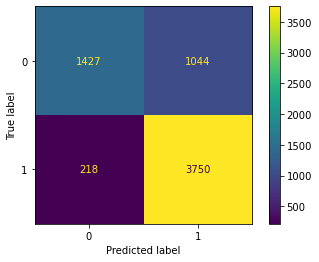

In [29]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

#LR model
final_LR_model = LogisticRegression(C=1, random_state=22)
final_LR_model.fit(X_remain_scale, y_remain)

#score on remain and test sets
print(f"training accuracy:{round(final_LR_model.score(X_remain_scale,y_remain),4)*100}%")
print(f"test accuracy:{round(final_LR_model.score(X_test_scale,y_test),4)*100}%")


# LR has the highest accuracy rate on the test set, so here is the confusion matrix

# Get class predictions
y_pred = final_LR_model.predict(X_test_scale)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Good Review", "Predicted Bad Review"],
    index=["True Good Review", "True Bad Review"]
)

plot_confusion_matrix(final_LR_model, X_test_scale, y_test);

In [30]:
f"That is a {(round(final_LR_model.score(X_test_scale, y_test), 4) - base_rate)*100}% improvement on base."

'That is a 18.779461373590532% improvement on base.'

This model has pretty good accuracy and is very good at predicting adoptable dogs, but it is struggling to predict which dogs will not be adopted which would end up costing the shelter valuable resources. I will look into PCA and see if this can help reduce errors and or improve runtime of this model. 

## Logistic Regression Using PCA
<a class="anchor" id="pca"></a>

Now that the logistic regression has been hyper parameterized, I will see if it is possible to use PCs (principle component analysis) to improve run time on the logistic regression model without losing predictive power in the model. 

In [31]:
# Instantiate & fit PCA model to the train data
# Default n_components will generate the same number of PCs as you have features 
my_PCA = PCA()
my_PCA.fit(X_train_scale)

# transform train and validation data using the PCs created
X_train_PCA = my_PCA.transform(X_train_scale)
X_val_PCA = my_PCA.transform(X_val_scale)

In [32]:
#print out the PCs for visual inspection
for i in range(len(my_PCA.explained_variance_ratio_)):
    print(f"Proportion of variance captured by PC{i}: {my_PCA.explained_variance_ratio_[i]: 0.3f}")

Proportion of variance captured by PC0:  0.049
Proportion of variance captured by PC1:  0.045
Proportion of variance captured by PC2:  0.032
Proportion of variance captured by PC3:  0.028
Proportion of variance captured by PC4:  0.025
Proportion of variance captured by PC5:  0.024
Proportion of variance captured by PC6:  0.024
Proportion of variance captured by PC7:  0.023
Proportion of variance captured by PC8:  0.022
Proportion of variance captured by PC9:  0.022
Proportion of variance captured by PC10:  0.021
Proportion of variance captured by PC11:  0.021
Proportion of variance captured by PC12:  0.020
Proportion of variance captured by PC13:  0.020
Proportion of variance captured by PC14:  0.020
Proportion of variance captured by PC15:  0.020
Proportion of variance captured by PC16:  0.019
Proportion of variance captured by PC17:  0.019
Proportion of variance captured by PC18:  0.019
Proportion of variance captured by PC19:  0.019
Proportion of variance captured by PC20:  0.019
Pr

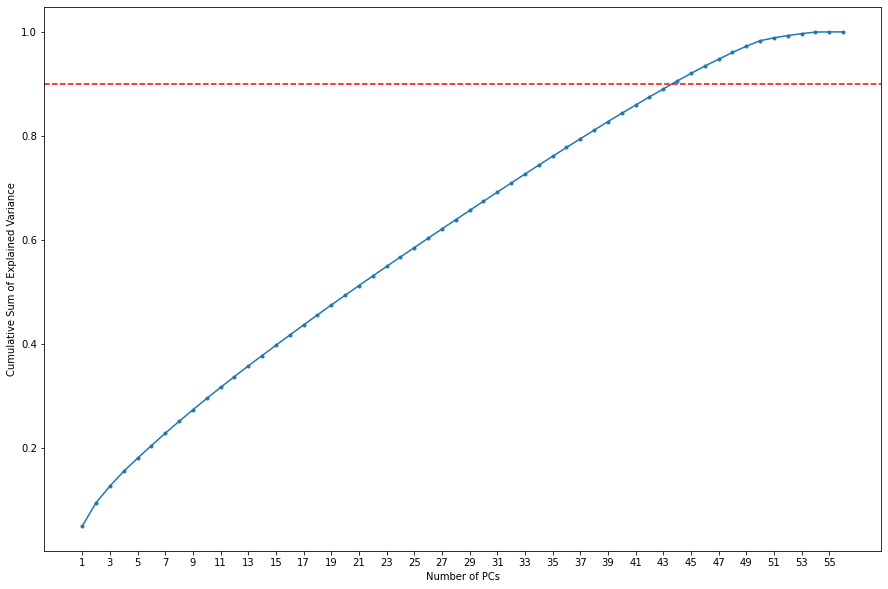

In [33]:
# Pull out the explained variance ratios
expl_var = my_PCA.explained_variance_ratio_

# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)

# Plot out the cumulative sum graph
plt.figure(figsize=(15,10))
plt.plot(range(1,57), cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(1,57,2))
plt.show()

This model will need a lot of PCs to explain 90% of the variance. With that in mind I will optimize the number of PCs needed below. 

In [34]:
from sklearn.model_selection import cross_val_score

# Instantiate model 

train_score = []
val_score = []
cross_validation_scores_train = []
cross_validation_scores_val = []

for i in range(1, 55):
    # Instantiate
    logistic_regression_model = LogisticRegression(C=1 , max_iter=10000 , penalty='l2' , solver ='lbfgs' , random_state=1)
    my_PCA = PCA(n_components = i, random_state=1)
        
    #fit PCA
    my_PCA.fit(X_train_scale)

    # Transform train and val
    X_train_PCA = my_PCA.transform(X_train_scale)
    X_val_PCA = my_PCA.transform(X_val_scale)

    # Fit LR
    LR_model = logistic_regression_model.fit(X_train_PCA, y_train)

    # the cross validation score (mean of scores from all folds)
    cv_score_train = np.mean(cross_val_score(LR_model, X_train_PCA, y_train, cv = 5))
    cv_score_val = np.mean(cross_val_score(LR_model, X_val_PCA, y_val, cv = 5))

    cross_validation_scores_train.append(cv_score_train)
    cross_validation_scores_val.append(cv_score_val)


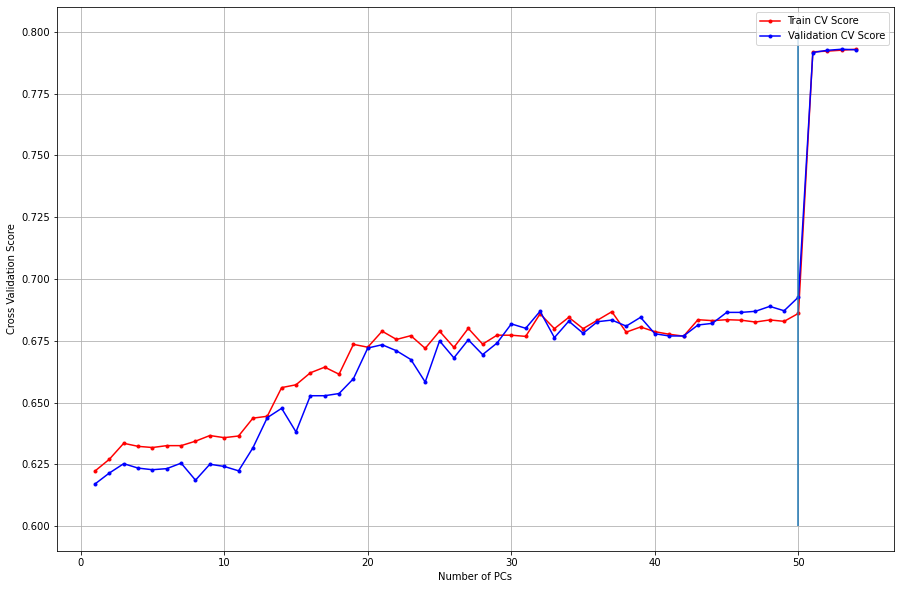

In [35]:
#ploting the CV scores from PCA logreg
plt.figure(figsize=(15,10))
plt.plot(range(1,55), cross_validation_scores_train,label="Train CV Score",marker='.', color="red")
plt.plot(range(1,55), cross_validation_scores_val,label="Validation CV Score",marker='.', color="blue")
plt.legend()
plt.vlines(50, 0.6, 0.8)
plt.xlabel('Number of PCs')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

The ideal PC count is 50. This is not a huge reduction in dimensions, but I will still build a model with this PC count and fit it on the train+val sets and test it with the test set to see how well this model runs. 

In [36]:
logistic_regression_model = LogisticRegression(C=1 , max_iter=10000 , penalty='l2' , solver ='lbfgs' , random_state=1)
my_PCA = PCA(n_components = 50, random_state=1)
        
#fit PCA
my_PCA.fit(X_train_scale)

# Transform train and test
X_remain_PCA = my_PCA.transform(X_remain_scale)
X_test_PCA = my_PCA.transform(X_test_scale)

# Fit LR
LR_PCA_model = logistic_regression_model.fit(X_remain_PCA, y_remain)

#score and print the accuracy of remain/test sets
print(f"training accuracy:{round(LR_PCA_model.score(X_remain_PCA,y_remain),4)*100}%")
print(f"test accuracy:{round(LR_PCA_model.score(X_test_PCA,y_test),4)*100}%")

training accuracy:68.95%
test accuracy:68.49%


This accuracy is a lot lower and the dimensions reduction is very minor. It seems PCA is not optimal for this dataset because each PC explains too little of the variance on it's own, thus I would need to use most of the PCs to keep the high accuracy scores I am seeing from the logistic regression. Since using PCs actually reduces explainability of the model, I will opt not to use this model. Next, I will tun a random forest model. 

## Tuning a Random Forest Model
<a class="anchor" id="forest"></a>

Similar to how I optimized the logistic regression model, I will run a grid search on a random forest model to hyper parametrize these features:

* n_estimators = number of trees in the forest
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [37]:
# define search space for the gris search
space1 = dict()
space1['n_estimators'] = [1, 100, 1000]
space1['max_depth'] = [1, 25, 50]

In [38]:
#instantiate the model
forest_model = RandomForestClassifier(random_state=3)

# define search
search1 = GridSearchCV(forest_model, space1, scoring='accuracy', cv=5)

In [39]:
#run the grid search on the log reg model
forest_result = search1.fit(X_remain, y_remain)

In [40]:
# summarize result
print('Best Score: %s' % forest_result.best_score_)
print('Best Hyperparameters: %s' % forest_result.best_params_)

Best Score: 0.8031689527662508
Best Hyperparameters: {'max_depth': 25, 'n_estimators': 1000}


According to this grid search, the optimal parameters for a random forest model are:

* 'max_depth': 25
* 'n_estimators': 1000

I will use these parameters moving forward to fit a random forest model and evaluate it on the test data. 

### Random Forest Evaluation
<a class="anchor" id="foresteval"></a>

Now that the optimal parameters are known. I will test it on the test set and evaluate how the model does in accuracy, precision and recall compared to the logistic regression above. 

In [41]:
final_forest_model = RandomForestClassifier(max_depth = 25, n_estimators=1000, random_state=3)
final_forest_model.fit(X_remain, y_remain)

print(f"The TRAIN classification accuracy is:  {round(final_forest_model.score(X_remain,y_remain),4)*100}%")
print(f"The TEST classification accuracy is:  {round(final_forest_model.score(X_test,y_test),4)*100}%")


The TRAIN classification accuracy is:  99.27%
The TEST classification accuracy is:  81.22%


In [42]:
print(round(final_forest_model.score(X_test,y_test) - base_rate, 4)*100, '% improvement over base rate')

19.6 % improvement over base rate


This is quite a bit of over fitting, but the the test accuracy has a marginal improvement on the logistic regression model. 

The TRAIN classification accuracy is:  99.27%
The TEST classification accuracy is:  81.22%


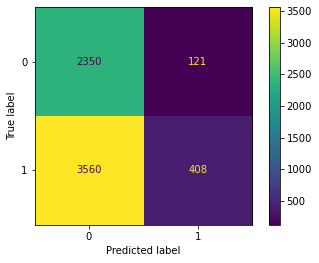

In [43]:
Forest_model = RandomForestClassifier(max_depth = 25, n_estimators=1000, random_state=3)
Forest_model.fit(X_remain, y_remain)

print(f"The TRAIN classification accuracy is:  {round(Forest_model.score(X_remain,y_remain),4)*100}%")
print(f"The TEST classification accuracy is:  {round(Forest_model.score(X_test,y_test),4)*100}%")


# Get class predictions
y_pred = Forest_model.predict(X_test_scale)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Good Review", "Predicted Bad Review"],
    index=["True Good Review", "True Bad Review"]
)

plot_confusion_matrix(Forest_model, X_test_scale, y_test);

This model has a very similar accuracy score to the logistic regression model, but the recall and precision are opposites. This model is predicting almost all dogs will not be adopted. This would likely save the shelter some time and resources, but would have a grim outlook for the dog up for adoption. Remember that dogs that are deemed "unadoptable" may be transfered to another facility, but they also have a chance of being euthanized.

# Comparing the Models
<a class="anchor" id="compare"></a>

The logistical regression makes significantly more false positive predictions than false negatives. This means it predicts dogs are adoptable, when they are in fact not. This raises expenses at the shelter and fills up kennels that might be desperately needed. Random Forest has significantly more false negatives meaning dogs are labeled unlikely to get adopted. This can result in dogs being transfered prematurely or potentially even euthanized. In this case, both kinds of errors are bad depending on the shelter's situation. If you have false positives, the shelter could have too many dogs and higher expenses - if you have a false negative you could be preventing a dog from being adopted. Which model a shelter chooses would have to depend on their needs and expectations. If the shelter has reliable donors and can afford a few extra dogs in their facilities, the logistic regression is preferred. If a shelter is barely getting by and potentially facing foreclosure, using the random forest model would make sense for them.